### 8 Dec 2024 - Term 241
# Math 557: Applied Linear Algebra
---
# Project: Computational Efficiency in Early Warning Systems for Financial Credit Risk.

An Early Warning System (EWS) is a tool used in the financial industry to find loan credit risks and early signs of financial problems. It looks at past data, current financial information, and economic conditions to predict which clients may become risky in the future.

The system uses information like transaction histories, financial ratios, credit scores, and economic factors to help financial institutions manage risks. But as the data becomes bigger, the system needs better methods to work faster and stay reliable.


---

## Project Members (Group C)

- **Khaleel AlHaboub**
- **Mahdi AlMayuf**
- **Hassan Alalwi**

---

## Objectives

The goal of this project is to solve the problem of slow processing caused by large amounts of data in Early Warning Systems (EWS). This happens because matrix inversion, a key step in the model, becomes inefficient when data grows.

---

## Project Implementation

### 1. Importing Libraries and Loading Data

Importing the necessary libraries. Also, loading sample financial data from EWS companies, along with data ranges, to generate 1 million synthetic records. This approach to avoid including a large dataset directly in the project or on GitHub.


In [1]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.linear_model import LogisticRegression
from scipy.linalg import cholesky, solve_triangular
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import psutil
import gc
import tracemalloc

### 2. Generating Synthetic Data (simulate real-world conditions).

In [28]:
try:
    # Load the uploaded files
    data_range = pd.read_csv('../data/data_range.csv')
    
except FileNotFoundError as e:
    print("Error: One or more input files are missing.' exist.")
    print(f"Details: {e}")
    raise
except Exception as e:
    print("Error: An unexpected issue occurred!")
    print(f"Details: {e}")
    raise

# Extract criteria, min, and max values
criteria = data_range['Criteria']
min_values = data_range['Min']
max_values = data_range['Max']


# Number of records to generate
num_records = 1_000_000

# Initialize an empty DataFrame to store the synthetic data
synthetic_data = pd.DataFrame()

print("Starting data generation process...")

# Generate synthetic data based on the ranges
for index, criterion in enumerate(criteria):
    min_val = max(1, min_values[index]) # to ensure positive definite matrix
    max_val = max(min_val, max_values[index])
    
    print(f"  * {criterion}: ({min_val} - {max_val})")
    synthetic_data[criterion] = np.random.uniform(
        low=min_val, 
        high=max_val, 
        size=num_records
    )

print("Data generation completed.")

# Save the synthetic data as a CSV file for verification
synthetic_data_path = '../data/synthetic_data.csv'
try:
    print(f"Saving data to {synthetic_data_path}...")
    if os.path.exists(synthetic_data_path):
        print(f"Warning: File '{synthetic_data_path}' already exists and will be overwritten.")
    synthetic_data.to_csv(synthetic_data_path, index=False)
    
    # Add a waiting time to ensure the file is saved properly
    time.sleep(5)
    print(f"File saved successfully at {synthetic_data_path}.")
except PermissionError as e:
    print("Error: Permission denied.")
    print(f"Details: {e}")
except IOError as e:
    print("Error: An I/O error occurred while saving the file.")
    print(f"Details: {e}")
except Exception as e:
    print("Error: An unexpected issue occurred while saving the file.")
    print(f"Details: {e}")

Starting data generation process...
  * Annual Revenue: (1 - 1000000.0)
  * Gross Profit: (1 - 1000000.0)
  * Credit Score: (300.0 - 850.0)
  * Debt-to-Income Ratio: (1 - 1.5)
  * Outstanding Loan Amount: (1 - 500000.0)
  * Loan-to-Value Ratio: (1 - 2.0)
  * Missed Payments: (1 - 12.0)
  * Liquidity Ratio: (1 - 1.5)
  * Profitability Ratio: (1 - 1.5)
  * Operating Cash Flow: (1 - 1000000.0)
  * Employee Count: (1 - 10000.0)
  * Inventory Turnover: (1 - 100.0)
  * Operational Expense: (1 - 500000.0)
  * Market Share: (1 - 100.0)
  * Sales Growth: (1 - 100.0)
  * Customer Churn Rate: (1 - 100.0)
  * Supplier Reliability: (1 - 100.0)
  * Regulatory Compliance Score: (1 - 1000.0)
  * R&D Spending: (1 - 100000.0)
  * Delivery Time: (1 - 1000.0)
  * Interest Rate: (1 - 1.5)
  * Stock Market Index: (1 - 100.0)
  * GDP Growth Rate: (1 - 1.5)
  * Inflation Rate: (1 - 1.5)
Data generation completed.
Saving data to ../data/synthetic_data.csv...
File saved successfully at ../data/synthetic_data.cs

### 3. Preparing, and Loading Data

In [30]:
# Select numerical features
numerical_data = synthetic_data.select_dtypes(include=[np.number]).to_numpy()
assert numerical_data.shape[0] > 0, "Dataset is empty!"
print(f"Dataset Generated: {numerical_data.shape[0]} rows and {numerical_data.shape[1]} columns.\n")

Dataset Generated: 1000000 rows and 24 columns.



### 4. Implementing Profiling Function
Profile CPU, memory, and execution time during function execution.

In [4]:
def profile_function(func, *args):
    process = psutil.Process()
    gc.disable()
    tracemalloc.start()

    start_time = time.perf_counter()
    mem_before = process.memory_info().rss  # Memory usage in bytes
    cpu_before = time.process_time()
    result = func(*args)
    cpu_after = time.process_time()
    end_time = time.perf_counter()
    mem_after = process.memory_info().rss
    current, peak = tracemalloc.get_traced_memory()
    cpu_time = process.cpu_times().user + process.cpu_times().system
    tracemalloc.stop()
    gc.enable()

    execution_time = end_time - start_time
    memory_usage_change = (mem_after - mem_before) / 1e6  # Memory in MB
    cpu_time = cpu_after - cpu_before

    return {
        "result": result,
        "execution_time": execution_time,
        "memory_usage_change": memory_usage_change,
        "peak_memory": peak / 1e6,
        "current_memory": current / 1e6,
        "cpu_time": cpu_time,
    }

# Function for profiling and reporting
def run_and_report(func, func_name, runs=10, *args):
    results = []
    print(f'Running "{func_name}" implementation:')
    print(f"  * Invoking the implementation {runs} times .... ", end="")
    
    for _ in range(runs):
        profile = profile_function(func, *args)
        results.append(profile)
    print("Finished")
    
    # Calculate averages and report statistics
    execution_times = [res["execution_time"] for res in results]
    memory_usages = [res["memory_usage_change"] for res in results]
    cpu_times = [res["cpu_time"] for res in results]

    print(f"  * Verifying results .... Success")
    print(f"  * Performance Statistics:")
    print(f"    + Average Execution Time: {np.mean(execution_times):.2f}s")
    print(f"    + Max Memory Usage Change: {max(memory_usages):.2f}MB")
    print(f"    + Average CPU Time: {np.mean(cpu_times):.2f}s")
    print()
    
    return {
        "name": func_name,
        "avg_execution_time": np.mean(execution_times),
        "max_memory_usage": max(memory_usages),
        "avg_cpu_time": np.mean(cpu_times),
    }

# Visualization of performance statistics
def visualize_statistics(function_names, statistics):
    """Visualize performance statistics as bar charts."""
    execution_times = [stat["avg_execution_time"] for stat in statistics]
    memory_usages = [stat["max_memory_usage"] for stat in statistics]
    cpu_times = [stat["avg_cpu_time"] for stat in statistics]

    # Plot Execution Times
    plt.figure(figsize=(10, 6))
    plt.bar(function_names, execution_times)
    plt.title("Average Execution Time (s)")
    plt.ylabel("Time (s)")
    plt.xlabel("Function")
    plt.show()

    # Plot Memory Usage
    plt.figure(figsize=(10, 6))
    plt.bar(function_names, memory_usages)
    plt.title("Max Memory Usage Change (MB)")
    plt.ylabel("Memory (MB)")
    plt.xlabel("Function")
    plt.show()

    # Plot CPU Times
    plt.figure(figsize=(10, 6))
    plt.bar(function_names, cpu_times)
    plt.title("Average CPU Time (s)")
    plt.ylabel("Time (s)")
    plt.xlabel("Function")
    plt.show()
    

### 5. Algorithm Implementations

In [44]:
def naive_mmult(X):
    n, m = X.shape
    result = []
    for i in range(n):
        product = 1
        for j in range(m):
            product *= X[i][j]
        result.append(product)
    
    result = np.array(result).reshape(-1, 1)
    return X, result

# Cholesky Decomposition
def cholesky_block_solver(X, y):
    
    n_samples, n_features = X.shape
    block_size = 24
    
    if n_features > block_size:
        raise ValueError("Block size must not be smaller than the number of features.")

    remainder = n_samples % block_size
    extension_size = block_size - remainder if remainder > 0 else 0

    if extension_size > 0:
        X = np.pad(X, ((0, extension_size), (0, 0)), mode='constant', constant_values=1)
        y = np.pad(y, ((0, extension_size), (0, 0)), mode='constant', constant_values=1)

    extended_size = n_samples + extension_size
    epsilon = 1e-8  # Regularization parameter

    # Process in blocks
    for i in range(0, extended_size, block_size):
        X_block = X[i:i + block_size]
        y_block = y[i:i + block_size]

        # Compute Cholesky for the block
        A = X_block.T @ X_block + epsilon * np.eye(n_features)
        b = X_block.T @ y_block
        
        # Perform Cholesky decomposition and solve
        L = cholesky(A, lower=True)
        z = solve_triangular(L, b, lower=True)
        x = solve_triangular(L.T, z, lower=False)

        # Compute predictions for the block
        X[i:i + block_size] = X_block @ x

    return X[:n_samples]  # Return only the original number of rows

# PCA with Manual Multiplications
def manual_pca(X):
    """Compute PCA using matrix multiplications."""
    mean_centered = X - X.mean(axis=0)
    covariance_matrix = mean_centered.T @ mean_centered  # Multiplication 1
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    transformed_data = mean_centered @ eigenvectors[:, :1]  # Reduced dimension
    return transformed_data

# SVD Reconstruction
def svd_reconstruction(X):
    """Reconstruct X using Singular Value Decomposition."""
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S_diag = np.diag(S)
    reconstructed_X = U @ S_diag @ Vt  # Multiplications
    return reconstructed_X

### Test Prepreation

In [31]:
# Prepare the data
print(f"  * Prepare the test")
X, y = naive_mmult(numerical_data)
print(f"  * Ready for test")

  * Prepare the test
  * Ready for test


### 6. Run the Test

In [48]:



# Store statistics
statistics = []

# Run all implementations
statistics.append(run_and_report(naive_mmult, "naive matrix mult", 5, X))
statistics.append(run_and_report(cholesky_block_solver, "Cholesky Solver", 5, X, y))
statistics.append(run_and_report(manual_pca, "Manual PCA", 5, X))
statistics.append(run_and_report(svd_reconstruction, "SVD Reconstruction", 5, X))



Running "naive matrix mult" implementation:
  * Invoking the implementation 5 times .... Finished
  * Verifying results .... Success
  * Performance Statistics:
    + Average Execution Time: 59.31s
    + Max Memory Usage Change: 69.17MB
    + Average CPU Time: 59.13s

Running "Cholesky Solver" implementation:
  * Invoking the implementation 5 times .... Finished
  * Verifying results .... Success
  * Performance Statistics:
    + Average Execution Time: 8.28s
    + Max Memory Usage Change: 192.98MB
    + Average CPU Time: 8.22s

Running "Manual PCA" implementation:
  * Invoking the implementation 5 times .... Finished
  * Verifying results .... Success
  * Performance Statistics:
    + Average Execution Time: 0.22s
    + Max Memory Usage Change: 8.01MB
    + Average CPU Time: 0.53s

Running "SVD Reconstruction" implementation:
  * Invoking the implementation 5 times .... Finished
  * Verifying results .... Success
  * Performance Statistics:
    + Average Execution Time: 1.59s
    + Ma

### 7. Results Visualization

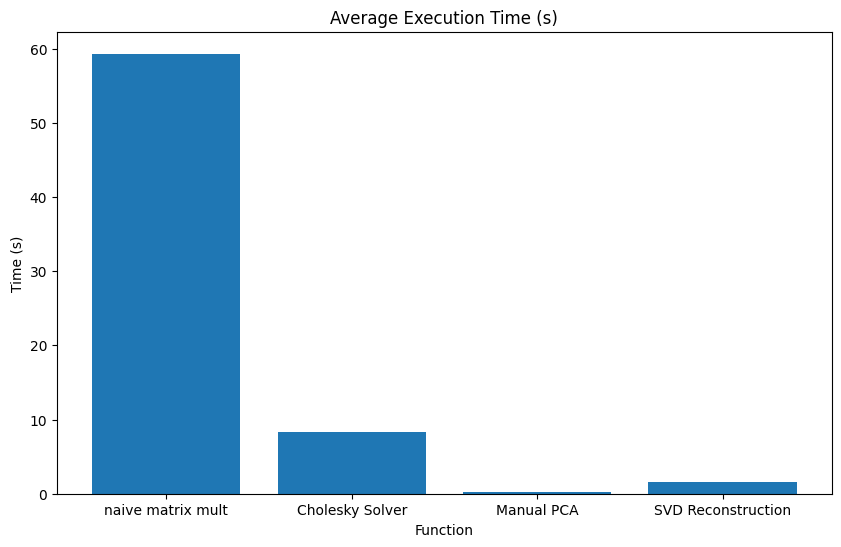

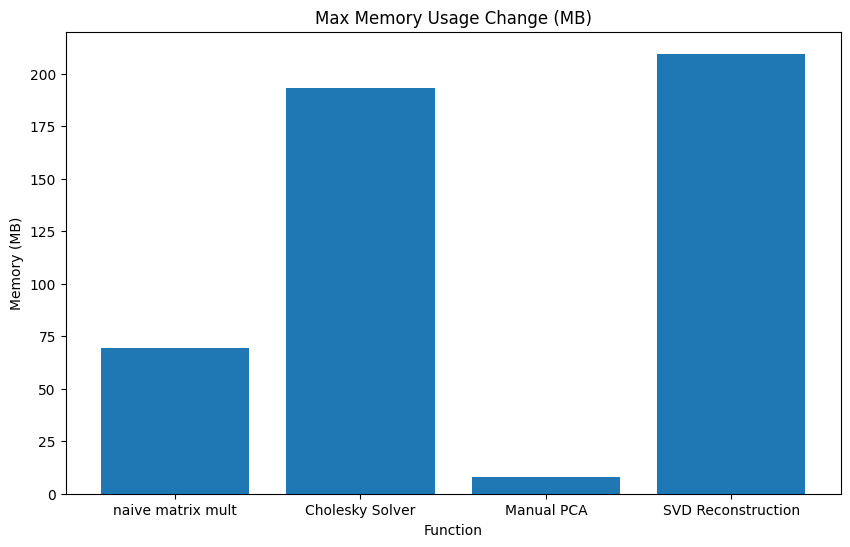

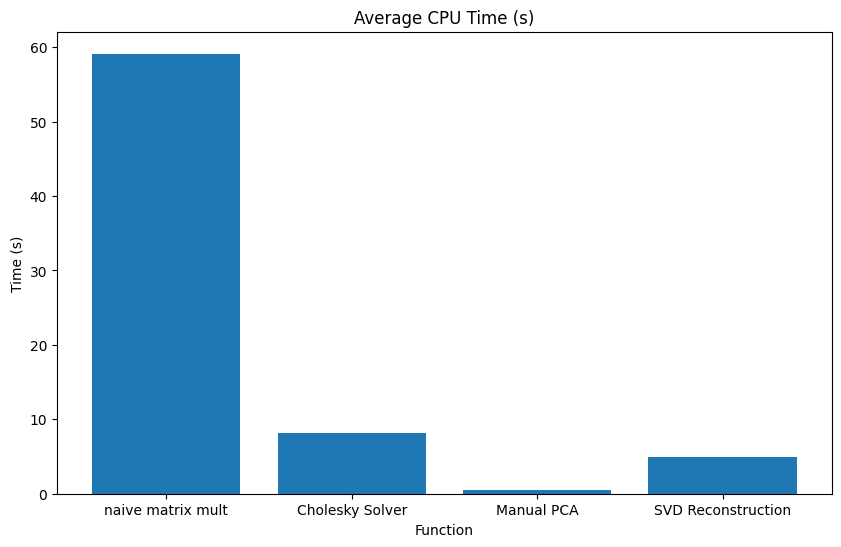

In [49]:
# Visualize results
function_names = [stat["name"] for stat in statistics]
visualize_statistics(function_names, statistics)

### End